## Travelling Salesman problem

In [2]:
!pip install -r "requirements_unix.txt"

Processing ./dadk_light_3.10.tar.bz2
  Preparing metadata (setup.py) ... done
  Created wheel for dadk: filename=dadk-2023.12.10-py3-none-any.whl size=4995459 sha256=42685e546be31b7a12dc5357e9016df2d08bd296cff778b1ac6b9dd6599f12d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-lgt3171i/wheels/78/36/68/08dcbec0b48f137a33fc3ac474d3838f74984d2dda7e3178dd
Successfully built dadk
  Attempting uninstall: dadk
    Found existing installation: dadk 2023.12.10
    Uninstalling dadk-2023.12.10:
      Successfully uninstalled dadk-2023.12.10


In [4]:
!pip install dadk


In [5]:
%matplotlib widget
from IPython.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))

Lets start step by step.
Your first task is the following.
Choose five cities and store them as strings in a list `cities`. Also define a dictionary `distances` with distances between the cities. The distances do not have to be realistic.

## Generate the Dataset

In [33]:

from IPython.display import display, HTML
from dadk.Solution_SolutionList import *
from dadk.BinPol import *
import random
import numpy as np
import itertools
import time



random.seed(42)
cities = [
    "Munich", "Hamburg", "Stuttgart", "Berlin", "Frankfurt",
    "Paris", "Madrid", "Barcelona", "Tenerife", "Malaga",
    "Valencia", "Sevilla", "Lisboa", "Roma",
    "London", "Brussels", "Amsterdam", "Zurich", "Vienna",
    "Prague", "Warsaw", "Budapest", "Athens", "Dublin",
    "Copenhagen", "Oslo", "Stockholm", "Helsinki", "Reykjavik"
]

n = len(cities)

distances = {}
for cindex1 in range(len(cities)-1):
    c1 = cities[cindex1]
    for cindex2 in range(cindex1+1,len(cities)):
        c2 = cities[cindex2]
        distances[c1,c2] = random.randint(1,6)
        distances[c2,c1] = distances[c1,c2]

#distances2 = {}
#distances2 = np.zeros((n, n), dtype=int)
#for i in range(n):
 #   for j in range(i + 1, n):
#        distances2[i, j] = distances2[j, i] = random.randint(1, 6)

#print("Distance Matrix:")
#print(distances2)

print(distances)

distance_matrix = np.zeros((n, n), dtype=int)
for (c1, c2), dist in distances.items():
    i, j = cities.index(c1), cities.index(c2)
    distance_matrix[i, j] = distance_matrix[j, i] = dist

print("Distance Matrix:")
print(distance_matrix)


{('Munich', 'Hamburg'): 6, ('Hamburg', 'Munich'): 6, ('Munich', 'Stuttgart'): 1, ('Stuttgart', 'Munich'): 1, ('Munich', 'Berlin'): 1, ('Berlin', 'Munich'): 1, ('Munich', 'Frankfurt'): 6, ('Frankfurt', 'Munich'): 6, ('Munich', 'Paris'): 3, ('Paris', 'Munich'): 3, ('Munich', 'Madrid'): 2, ('Madrid', 'Munich'): 2, ('Munich', 'Barcelona'): 2, ('Barcelona', 'Munich'): 2, ('Munich', 'Tenerife'): 2, ('Tenerife', 'Munich'): 2, ('Munich', 'Malaga'): 6, ('Malaga', 'Munich'): 6, ('Munich', 'Valencia'): 1, ('Valencia', 'Munich'): 1, ('Munich', 'Sevilla'): 6, ('Sevilla', 'Munich'): 6, ('Munich', 'Lisboa'): 6, ('Lisboa', 'Munich'): 6, ('Munich', 'Roma'): 5, ('Roma', 'Munich'): 5, ('Munich', 'London'): 1, ('London', 'Munich'): 1, ('Munich', 'Brussels'): 5, ('Brussels', 'Munich'): 5, ('Munich', 'Amsterdam'): 4, ('Amsterdam', 'Munich'): 4, ('Munich', 'Zurich'): 1, ('Zurich', 'Munich'): 1, ('Munich', 'Vienna'): 1, ('Vienna', 'Munich'): 1, ('Munich', 'Prague'): 1, ('Prague', 'Munich'): 1, ('Munich', 'War

**texto en negrita**### Create the VarShapeSet

In [34]:
from dadk.QUBOSolverCPU import *
N = len(cities)
T = N
my_constant_bits = np.full((N,N), -1, np.int8)


## Start coding here: create an array called tsp_array with a (5,5) shape and axis_names=['time','city']
my_bit_shape_array = BitArrayShape(name='tsp_array', shape=(N,N), axis_names=['time','city'], constant_bits=my_constant_bits)
#

my_varshapeset2 = VarShapeSet(my_bit_shape_array)

my_varshapeset = VarShapeSet(*[my_bit_shape_array])
print(my_varshapeset2)
print(my_varshapeset)

"tsp_array" (29, 29)  ['time', 'city']
"tsp_array" (29, 29)  ['time', 'city']




```
# Tiene formato de código
```

### Creates the QUBO model

In [35]:
A, B, C, D = 1, 10, 10, 10
# H: Termino de la distancia
H = BinPol(my_varshapeset)
for t in range(T):
    for c1_index, c1 in enumerate(cities):
        for c2_index, c2 in enumerate(cities):
            if c1 != c2:
                dist = distances[(c1, c2)]
                H.add_term(dist, ('tsp_array', t, c1_index), ('tsp_array', (t + 1) % T, c2_index))

# H1: Restricción de cada ciudad se visita exactamente una vez
H1 = BinPol(my_varshapeset)
for c in range(N):
    H1_c = BinPol(my_varshapeset)
    for t in range(T):
        H1_c.add_term(1, ('tsp_array', t, c))
    H1_c.add_term(-1, ())
    H1_c.power(2)
    H1 += H1_c

# H2: Restricción de que cada ciudad se visita exactamente en un tiempo
H2 = BinPol(my_varshapeset)
for t in range(T):
    H2_t = BinPol(my_varshapeset)
    for c in range(N):
        H2_t.add_term(1, ('tsp_array', t, c))
    H2_t.add_term(-1, ())
    H2_t.power(2)
    H2 += H2_t

# H3: Restricciones MTZ para eliminar subciclos
H3 = BinPol(my_varshapeset)
u = {i: i + 1 for i in range(1, N)}

for i in range(1, N):
    for j in range(1, N):
        if i != j:
            H3.add_term(D * (N - 1), ('tsp_array', 0, i), ('tsp_array', 1, j))
            H3.add_term(D * (N - 1), ('tsp_array', 1, i), ('tsp_array', 0, j))
            H3.add_term(-2 * D, ('tsp_array', 0, i), ('tsp_array', 1, j))
            H3.add_term(-2 * D, ('tsp_array', 1, i), ('tsp_array', 0, j))

# Combine the terms to form the QUBO
my_qubo = A * H + B * H1 + C * H2 + D * H3

[texto del enlace](https://)### Find the minima using QUBO Solver CPU

> Bloque con sangría



In [36]:
from dadk.QUBOSolverCPU import *
from dadk.QUBOSolverBase import *
import time
import psutil
import platform
import cpuinfo

def get_memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / 1024 / 1024  # Convertir a MB

initial_memory = get_memory_usage()

start_time = time.time()
solver = QUBOSolverCPU(
number_iterations=200000,
number_runs=10,
scaling_bit_precision=32,
auto_tuning=AutoTuning.AUTO_SCALING_AND_SAMPLING)
#cities = ["Munich", "Hamburg", "Stuttgart", "Berlin", "Frankfurt", "Paris", "Madrid", "Barcelona"]

solution_list = solver.minimize(my_qubo)
solution = solution_list.min_solution

end_time = time.time()
final_memory = get_memory_usage()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time:.2f} seconds")
print("Uso de memoria inicial:", initial_memory, "MB")
print("Uso de memoria final:", final_memory, "MB")
print("Incremento de uso de memoria:", final_memory - initial_memory, "MB")
print(solution.configuration)

result = []


# Process the configuration to extract the city names
config = solution.configuration

for t in range(T):
    row = []
    for c in range(N):
        idx = t * N + c
        if config[idx] == 1:
            row.append(cities[c])
        else:
            row.append(0)
    result.append(row)

print("CPU Solver Formatted Result:")

for row in result:
    print(row)


# Extract the route in order
route = []
for t in range(T):
    for c in range(N):
        idx = t * N + c
        if config[idx] == 1:
            route.append(cities[c])
            break  # Once we find the city for this time step, we can break the inner loop

# Print the route
print("Route in Order:")
print(" -> ".join(route))
# Calcular la distancia total

total_distance = 0
for i in range(len(route) - 1):
    city_from = cities.index(route[i])
    city_to = cities.index(route[i + 1])
    total_distance += distance_matrix[city_from][city_to]

# Para hacer que sea un viaje de ida y vuelta, agrega la distancia de la última ciudad de vuelta a la primera ciudad
city_from = cities.index(route[-1])
city_to = cities.index(route[0])
total_distance += distance_matrix[city_from][city_to]

# Imprimir la distancia total
print("Total Distance:", total_distance)
print(platform.processor())
cpu_info = cpuinfo.get_cpu_info()
print(cpu_info['brand_raw'])



********************************************************************************
Scaling qubo, temperature_start, temperature_end and offset_increase_rate
  factor:                       412460.00000
********************************************************************************


********************************************************************************
Effective values (including scaling factor)
  temperature_start:            15280000.000
  temperature_end:               3230000.000
  offset_increase_rate:          7963000.000
  duration:                            0.358 sec
********************************************************************************

Execution Time: 76.81 seconds
Uso de memoria inicial: 249.1171875 MB
Uso de memoria final: 257.94140625 MB
Incremento de uso de memoria: 8.82421875 MB
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Draw Solution

Value of constraint one city at each time: 0
Value of constraint one time for each city: 0


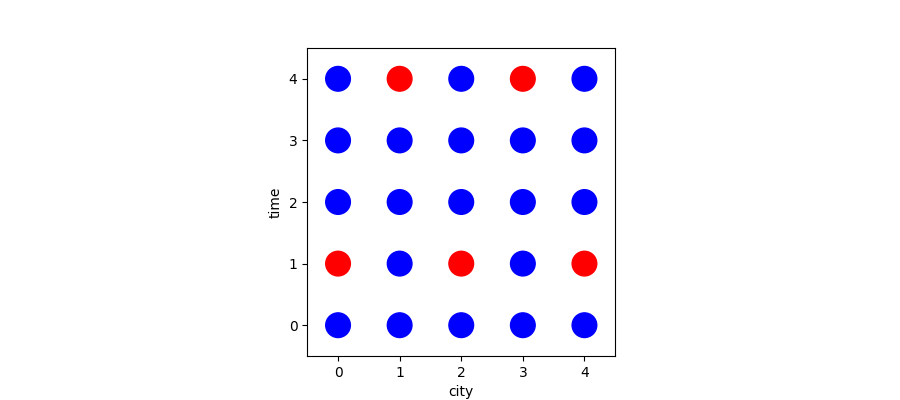

In [ ]:
print(f'Value of constraint one city at each time: {H1.compute(solution.configuration)}')
print(f'Value of constraint one time for each city: {H2.compute(solution.configuration)}')

#- Start coding here -######################################################################################################################
my_bit_array = solution.extract_bit_array("tsp_array")
my_bit_array.draw(order=[1,0])
######################################################################################################################- Stop coding here -#

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()